In [2]:
!nvidia-smi

Tue Sep 07 21:06:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108... WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   51C    P8    26W / 260W |    701MiB / 11264MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import dataloader
from time import time
import datetime
import os
import sys
from collections import OrderedDict
from multiprocessing import Pool

device = torch.device('cuda:0')
print(device)

%matplotlib inline

cuda:0


In [4]:
def time_cost(func):
    def Wrapper(*arg, **kargs):
        t0 = time()
        res = func(*arg, **kargs)
        t1 = time()
        print(f'[{func.__name__}] cost {t1-t0:.2f}s')
        
        return res
    return Wrapper        

# Pretrain Models

In [5]:
from transformers import AutoTokenizer, BertModel
path = '../a_nlp_resource/transformers/bert-base-chinese/'
tokenizer = AutoTokenizer.from_pretrained(path)
bert = BertModel.from_pretrained(path).to(device)
bert.training

False

In [19]:
"""
vocab
"""
vocab = list(tokenizer.vocab.keys())

In [6]:
x = tokenizer(["我的太阳", '我'], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)
y = bert(**x)
y[0][0].shape

torch.Size([20, 768])

In [7]:
y[0].reshape(2,-1).shape

torch.Size([2, 15360])

In [8]:
y[1].shape

torch.Size([2, 768])

In [9]:
tokenizer.mask_token

'[MASK]'

In [10]:
tokenizer.mask_token_id

103

In [11]:
tokenizer(["我的太阳", '我'], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)

{'input_ids': tensor([[ 101, 2769, 4638, 1922, 7345,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2769,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

In [78]:
tokenizer(["我的[MASK]阳[UNK]设"], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)

{'input_ids': tensor([[ 101, 2769, 4638,  103, 7345,  100, 6392,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

In [80]:
tokenizer.vocab['[MASK]'], tokenizer.vocab['[UNK]']

(103, 100)

# Dataset

In [ ]:
class SimilarityDataProcessor:
    """
    处理如下类型数据集
    [q1 q2 label]

    [idx q1 q2 label]
    """

    def __init__(self, logger=print):
        self.logger = logger

    @time_cost
    def read_data(self,mode, name, path, sep, encoder='utf-8', has_index=False):
        """
        读取数据,返回 list形式的数据
        
        mode: 读取数据的方式, 
              readline 
              pandas 
        """
        self.logger(f'-'*42)
        self.logger(f'start to read: [{name}]...')
        
        if mode == 'readline':
            data = self._read_data_by_readline(path=path, 
                                         sep=sep, 
                                         encoder=encoder,
                                         has_index=has_index)
        elif mode == 'pandas':
            data = self._read_data_by_pandas(path=path, 
                                       sep=sep, 
                                       encoder=encoder)
        else:
            raise Exception('mode的值有误')
        
        # logs
        self.logger(f'finish reading: [{name}]')
        self.logger('nums:',len(data))
        for i in range(5):
            self.logger(data[i])
        return data
    
    
    def _read_data_by_readline(self, path, sep, encoder='utf-8', has_index=False):
        data = []
        with open(path, encoding=encoder) as f:
            line = f.readline()
            while line:
                try:
                    # 预处理
                    line = line.strip()
                    line = line.replace('\ufeff', '')

                    if has_index:
                        idx, q1, q2, label = line.split(sep)
                    else:
                        q1, q2, label = line.split(sep)
                    data.append([q1, q2, label])

                    line = f.readline()
                except Exception as e:
                    print(f'line: {line}')
                    print('-'*42)
                    print(e)
                    sys.exit()     
        return data
    
    
    def _read_data_by_pandas(self,path, sep, encoder='utf-8'):
        data = pd.read_csv(path, sep=sep, encoding=encoder)
        data = data.to_numpy().tolist()
        return data
        

    def create_dataloader(self, data, batch_size, is_shuffle):
        dataloader = torch.utils.data.DataLoader(data,
                                                 batch_size=batch_size,
                                                 shuffle=is_shuffle)
        return dataloader
    
    
    
    
    ############################################
    #预处理
    ############################################
    def preprocessing(self, text):
        """
        单句处理
        """
        global vocab
        
        res = ''
        for i in text: 
            # 大写字母vocab里面没有
            i = i.lower() 
            
            # punctuation 
            if i =='…': 
                i = '.'
            elif i in ["'",'‘','’','“','”']: 
                i = "'"
            elif i in ['—', '―', '—', '`']: # 注意'-'互相不一样
                i = ','
            
            # char
            char_correct = {
                '壋':'增', '笫':'第', '囙':'回',
                '呮':'呗', '嚒':'么', '睌':'晚',
                '谝':'骗', '鍀':'得', '昰':'是',
                '伲':'呢', '肔':'服', '凊':'清',
                '挷':'绑', '亊':'事', '腨':'用',
                '戗':'钱', '玏':'功', '筘':'扣',
                '鈤':'日', '颃':'领', '讠':'之',
                '扥':'在', '螚':'能', '甪':'用',
                '茌':'花', '泝':'没', '牫':'我',
                '孒':'了', '镸':'长', '欹':'款',
                '刭':'到', '幵':'开', '怩':'呢',
                '绐':'给', '弍':'式', '淸':'清',
                '夂':'久', '叧':'另', '徣':'借',
                '冋':'回', '敉':'粒', '埭':'贷',
                '仧':'卡', '頟':'额', '捿':'捷',
                '鳓':'嘞', '䃼':'补', '囯':'国',
                '吿':'告'
            }
            if i in char_correct:
                i = char_correct[i]
                    
            # nonsense letter
            if i in [' ', ' ', '　', '　',' ',' ',
                     chr(8198), chr(65039), chr(8237), chr(8236),  # 一串打出来都是空格
                     '\u200d', '\x08','', '', 
                     '∨', '乛','∵', chr(8198),]:
                continue
                
            # UNK
            if i not in vocab:
                self.logger(text,'|',ord(i),'|',i)
                i = '[UNK]' # 这个UNK后面的 tokenizer可以处理
                    
                
            res += i 
        
        return res  
    
   
    def preprocess_similarity_data(self, data):
        """
        预处理形如 [[q1_1,q2_1,label_1], [q1_2,q2_2,label_2]] 的数据
        """
        q1,q2,label = list(zip(*data))
        q1 = [self.preprocessing(q) for q in q1]
        self.logger('q1 处理完毕')
        q2 = [self.preprocessing(q) for q in q2]
        self.logger('q2 处理完毕')
        
        res = list(zip(q1,q2,label))
        return res
    
    @time_cost
    def multi(self, work_num, func, data):
        """
        目前函数输入只有 data 
        """
        per_lenght = len(data)//(work_num-1) # 最后还有一个尾巴余量给最后一个work

        p = Pool()
        p_res = []
        for i in range(work_num):
            begin = per_lenght*i
            end = per_lenght*(i+1)
            p_res.append(p.apply_async(func, args=(data[begin:end],)))
        p.close()
        p.join()
        
        res = []
        for i in range(work_num):
            res.append(p_res[i].get())
        
        # 当 data 是 [[q1_1,q2_1,label_1], [q1_2,q2_2,label_2]] 数据时
        res = [j for i in res for j in i]
        return res

    
    
    ##################################################
    # mask data
    ##################################################
    
    def get_masked_text(self, text):
        """
        生成masked后的输入inputs,
        和对应的输出标签 labels, 里面0代表不需要预测,在计算loss时需要忽略
        """
        global vocab,tokenizers

        inputs = ''
        labels = []

        for i in text:
            if i not in vocab:
                print(f'UNK | {text} | {ord(i)} | {i}')
                i = '[UNK]'
            
            # preprocessing
            r = np.random.random()
            i_id = tokenizer.vocab[i]
            if r <= 0.15*0.8:
                inputs += '[MASK]'
                labels.append(i_id)
            elif r <= 0.15*0.9:
                inputs += np.random.choice(list(text))
                labels.append(i_id)
            elif r <= 0.15:
                inputs += i
                labels.append(i_id)
            else:
                inputs += i
                labels.append(0)

        return inputs, labels
    
    @time_cost
    def get_masked_data(self, data):
        """
        data = [q1,q2,q3,...]
        """
        input_data = []
        labels = []
        
        for i in data:
            temp_input, temp_labels = self.get_masked_text(i)
            input_data.append(temp_input)
            labels.append(temp_labels)
            
        self.logger('Inputs & labels:')
        for i in range(5):
            self.logger(input_data[i])
            self.logger(labels[i])
    
        return input_data, labels
    
data_processor = SimilarityDataProcessor()

In [ ]:
data_processor = SimilarityDataProcessor(logger=print) 

## atec

In [124]:
atec = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)

atec_add = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train_add.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)
atec = atec + atec_add

------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 39346
['怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号', '1']
['也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款', '0']
['花呗冻结以后还能开通吗', '我的条件可以开通花呗借款吗', '0']
['如何得知关闭借呗', '想永久关闭借呗', '0']
['花呗扫码付钱', '二维码扫描可以用花呗吗', '0']
[read_data] cost 0.05s
------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 63131
['为何我无法申请开通花呗信用卡收款', '支付宝开通信用卡花呗收款不符合条件怎么回事', '1']
['花呗分期付款会影响使用吗', '花呗分期有什么影响吗', '0']
['为什么我花呗没有临时额度', '花呗没有临时额度怎么可以负', '0']
['能不能开花呗老兄', '花呗逾期了还能开通', '0']
['我的怎么开通花呗收钱', '这个花呗是个什么啥？我没开通 我怎么有账单', '0']
[read_data] cost 0.06s


In [125]:
atec = data_processor.preprocess_similarity_data(atec)

q1 处理完毕
q2 处理完毕


## bq_corpus

In [126]:
path = './data/bq_corpus/'
bq_corpus_train = data_processor.read_data(mode='pandas',
                                           name='bq_corpus_train', 
                                           path=path+'train.csv', 
                                           sep=',',
                                           encoder='utf-8')

bq_corpus_val = data_processor.read_data(mode='pandas',
                                         name='bq_corpus_val', 
                                         path=path+'dev.csv', 
                                         sep=',',
                                         encoder='utf-8')

bq_corpus_test = data_processor.read_data(mode='pandas',
                                          name='bq_corpus_test', 
                                          path=path+'test.csv', 
                                          sep=',',
                                          encoder='utf-8')

------------------------------------------
start to read: [bq_corpus_train]...
finish reading: [bq_corpus_train]
nums: 100000
['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0]
['微信消费算吗', '还有多少钱没还', 0]
['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0]
['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0]
['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]
[read_data] cost 0.11s
------------------------------------------
start to read: [bq_corpus_val]...
finish reading: [bq_corpus_val]
nums: 10000
['不要借了我是试试看能否操作的', '借款审核期间能否取消借款', 0]
['亲怎样才能在钱包里有微粒货的图标呢', '借不到', 0]
['你好，我还款银行怎么更换', '怎么更换绑定还款的卡', 1]
['我的借贷额度，怎么减少了呢？', '微粒贷额度怎么才能降低', 0]
['什么时候可以知道借款成功', '2.多笔借款', 0]
[read_data] cost 0.14s
------------------------------------------
start to read: [bq_corpus_test]...
finish reading: [bq_corpus_test]
nums: 10000
['为什么我无法看到额度', '为什么开通了却没有额度', 0]
['为啥换不了', '为两次还都提示失败呢', 0]
['借了钱，但还没有通过，可以取消吗？', '可否取消', 1]
['为什么我申请额度输入密码就一直是那个页面', '为什么要输入支付密码来验证', 0]
['今天借 明天还款可以？', '今天借明天还要手续费吗', 0]
[read_data] cost 0.03s


In [127]:
bq_corpus_train = data_processor.preprocess_similarity_data(bq_corpus_train)

q1 处理完毕
q2 处理完毕


In [128]:
bq_corpus_val = data_processor.preprocess_similarity_data(bq_corpus_val)

q1 处理完毕
q2 处理完毕


In [129]:
"""
test 数据集也可以处理, 不过只使用训练集的经验知识来处理
"""
bq_corpus_test = data_processor.preprocess_similarity_data(bq_corpus_test)

(･ิϖ･ิ)っ看不到 | 3636 | ิ
(･ิϖ･ิ)っ看不到 | 982 | ϖ
(･ิϖ･ิ)っ看不到 | 3636 | ิ
伸请微粒货我到疷要等多久帮忙查下 | 30135 | 疷
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
(･ิϖ･ิ)っ看不到 | 3636 | ิ
(･ิϖ･ิ)っ看不到 | 982 | ϖ
(･ิϖ･ิ)っ看不到 | 3636 | ิ
如何还歀 | 27456 | 歀
伸请微粒货我到疷要等多久帮忙查下 | 30135 | 疷
如何还歀 | 27456 | 歀
q1 处理完毕
如何还歀 | 27456 | 歀
强烈要求增额﹉ | 65097 | ﹉
强烈要求增额﹉ | 65097 | ﹉
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
如何还歀 | 27456 | 歀
如何还歀 | 27456 | 歀
2⃣️十几分钟了都没有消息！还说三分钟搞定？？？ | 8419 | ⃣
强烈要求增额﹉ | 65097 | ﹉
q2 处理完毕


## build dataset

### mlm dataset

In [136]:
mlm_data = (list(zip(*bq_corpus_train))[0] 
            + list(zip(*bq_corpus_train))[1]
            + list(zip(*bq_corpus_val))[0]
            + list(zip(*bq_corpus_val))[1]
            + list(zip(*atec))[0]
            + list(zip(*atec))[1])
len(mlm_data)

424954

In [137]:
mlm_data = list(set(mlm_data))
print(len(mlm_data))
for i in range(5):
    print(mlm_data[i])

227826
花呗人脸验证，是本人为什么验证不了
借呗申请怎么填大学
今天蚂蚁借呗还款日到了，但没扣款
花呗如何重新绑定手机号
我每月都会提前还款，为什么我的蚂蚁借呗额度降低了


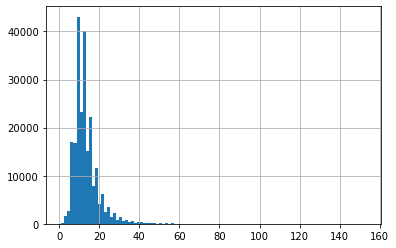

In [138]:
pd.Series(mlm_data).apply(lambda x : len(x)).hist(bins=100)

In [108]:
print(data_processor.get_masked_data('我的中国心'))
print(data_processor.get_masked_data('我的中国心'))
print(data_processor.get_masked_data('我的中国心'))

('我[MASK][MASK]国心', [0, 4638, 704, 0, 0])
('我的中国心', [0, 0, 0, 0, 0])
('我国中国心', [2769, 4638, 0, 0, 0])


In [139]:
mlm_input, mlm_label = data_processor.get_masked_data(mlm_data)

Inputs & labels:
花呗人脸验[MASK][MASK]是本人为[MASK]么验证不了
[0, 0, 0, 0, 0, 6395, 8024, 0, 0, 0, 0, 784, 0, 0, 0, 0, 0]
借呗申请怎么填大学
[0, 0, 0, 0, 0, 0, 0, 0, 0]
今天蚂蚁借呗还款日[MASK]了[MASK]但没扣款
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1168, 0, 8024, 0, 0, 0, 0]
[MASK]呗如何重新绑定号机号
[5709, 0, 0, 0, 0, 0, 0, 0, 2797, 0, 0]
我每月都会提前还款，为什么我的蚂蚁借[MASK]额度降低了
[0, 0, 0, 0, 0, 2990, 0, 0, 0, 0, 0, 0, 720, 0, 0, 0, 0, 0, 1446, 0, 0, 0, 0, 0]


In [140]:
import joblib

In [141]:
joblib.dump(mlm_input, 'mlm_input')
joblib.dump(mlm_label, 'mlm_label')

['mlm_label']

### similarity dataset

#### exchange 

In [15]:
train = bq_corpus_train
train[:5]

[['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0],
 ['微信消费算吗', '还有多少钱没还', 0],
 ['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0],
 ['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0],
 ['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]]

In [61]:
train_change = list(zip(*train))
train_change = [train_change[1],train_change[0],train_change[2]]
train_change = list(zip(*train_change))
train_change[:5]

[('4。  号码来微粒贷', '用微信都6年，微信没有微粒贷功能', 0),
 ('还有多少钱没还', '微信消费算吗', 0),
 ('怎么最近安全老是要改密码呢好麻烦', '交易密码忘记了找回密码绑定的手机卡也掉了', 0),
 ('什么时候可以到账', '你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', 0),
 ('你好，我的微粒贷怎么没有开通呢', '“微粒贷开通"', 0)]

In [62]:
train = train+train_change
len(train)

200000

In [63]:
"""
val, test
"""
val = bq_corpus_val
test = bq_corpus_test

len(val), len(test)

(10000, 10000)

## dataloader

In [5]:
batch_size = 32

In [6]:
train_loader = data_processor.create_dataloader(train, 
                                                batch_size=batch_size, 
                                                is_shuffle=True)

val_loader = data_processor.create_dataloader(val, 
                                              batch_size=batch_size, 
                                              is_shuffle=False)

test_loader = data_processor.create_dataloader(test, 
                                               batch_size=batch_size, 
                                               is_shuffle=False)

NameError: name 'data_processor' is not defined

# MLM

In [70]:
model_config = {
    'max_len':50,
    'hidden_size':768,
    'embedding_size': 21128
}

In [ ]:
class MlmBert(nn.Module):
    def __init__(self):
        global bert, tokenizer, model_config
   
        self.final_part = nn.Sequential(OrderedDict([
            ('final_Linear', 
             nn.Linear(model_config['hidden_size'],model_config['hidden_size'], bias=True)),
            ('final_layernorm', 
             nn.LayerNorm(model_config['hidden_size'],eps=1e-12)),
            ('final_embedding', 
             nn.Linear(model_config['hidden_size'], model_config['embedding_size'], bias=False))  
        ]))
        
        embedding_p = [p for p in bert.embeddings.word_embeddings.parameters()][0].T
        final_part.final_embedding.weight.data=embedding_p
        

    def forward(self,q1,q2):
        
        
        
        return h   
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def save(self, path='./sbert.model'):
        torch.save(self.state_dict(), path)
        
    def load(self, path='./sbert.model'):
        self.load_state_dict(torch.load(path)) 